# Week 4 NLP Disaster Tweets Kaggle Project

## Step 1. Brief description of the problem and data

### Problem and goals
While twitter can be a powerful tool for broadcasting real-time disaster information, the informal and often metaphorical nature of language on the platform creates a significant challenge. The goal is to build a machine learning method that can automatically classify tweets as either reporting a genuine disaster or not. This model will help organizations filter out irrelevant noise and respond more effectively to real-world emergencies.

### Data
- **Source:** Publicly available website Kaggle: https://www.kaggle.com/c/nlp-getting-started/overview
- **Structure:** The data is split into a train and a test data.
- **Size:** Train set (N=7613) and Test set (N=3263)
- **Dimensions:** id, text, location, keyword, target (train.csv only: 1=real disaster; 0=no)


### Data prep

In [61]:
!pip install -q tensorflow
!pip install -q wordcloud
!pip install -q keras_tuner

In [82]:
# --- 0. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# --- 0. Download NLTK data
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet')

sns.set(style="whitegrid")

### Data loading

In [41]:
# --- 1 Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# --- 2. Inspect the Data ---
print("--- Training Data Info ---")
print(f"Shape: {train_df.shape}")
print("\nFirst 5 rows:")
print(train_df.head())
print("\nData Types and Non-Null Values:")
train_df.info()

print("\n\n--- Test Data Info ---")
print(f"Shape: {test_df.shape}")
print("\nFirst 5 rows:")
print(test_df.head())

--- Training Data Info ---
Shape: (7613, 5)

First 5 rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Data Types and Non-Null Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
d

## Step 2. Exploratory Data analysis (EDA) -- Inspect, visualize, and clean the data

### Data cleaning

#### To prepare the tweet text for analysis, I first standardized it by converting everything to lowercase and removing irrelevant noise like URLs, HTML tags, and punctuation. 
#### I then filtered out common English stopwords (like "the", "a", "in") and used lemmatization to simplify words to their root form, ensuring that terms like "running" and "run" are treated as the same concept. 
#### Finally, I handled missing values in the keyword and location columns by filling them with a "none" placeholder to create a complete and clean dataset.

In [42]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Function to clean tweet text.
    - Removes URLs
    - Removes HTML tags
    - Converts to lowercase
    - Removes punctuation and special characters
    - Removes stopwords
    - Performs lemmatization
    """
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords, then lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)

# Apply the cleaning function to the 'text' column of both dataframes
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Handle missing values in 'keyword' and 'location' by filling with 'none'
train_df['keyword'].fillna('none', inplace=True)
test_df['keyword'].fillna('none', inplace=True)
train_df['location'].fillna('none', inplace=True)
test_df['location'].fillna('none', inplace=True)

print("Data cleaning complete. 'cleaned_text' column added.")
print("\n--- Sample of Cleaned Data ---")
print(train_df[['text', 'cleaned_text']].head())

Data cleaning complete. 'cleaned_text' column added.

--- Sample of Cleaned Data ---
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


/var/folders/65/z522s0gs7vbcv6ch0_n_v8600000gp/T/ipykernel_7186/2295552733.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('none', inplace=True)
/var/folders/65/z522s0gs7vbcv6ch0_n_v8600000gp/T/ipykernel_7186/2295552733.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

### Exploratory Data Analysis

/var/folders/65/z522s0gs7vbcv6ch0_n_v8600000gp/T/ipykernel_7186/3292274213.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=train_df, palette=['#3498db', '#e74c3c'])


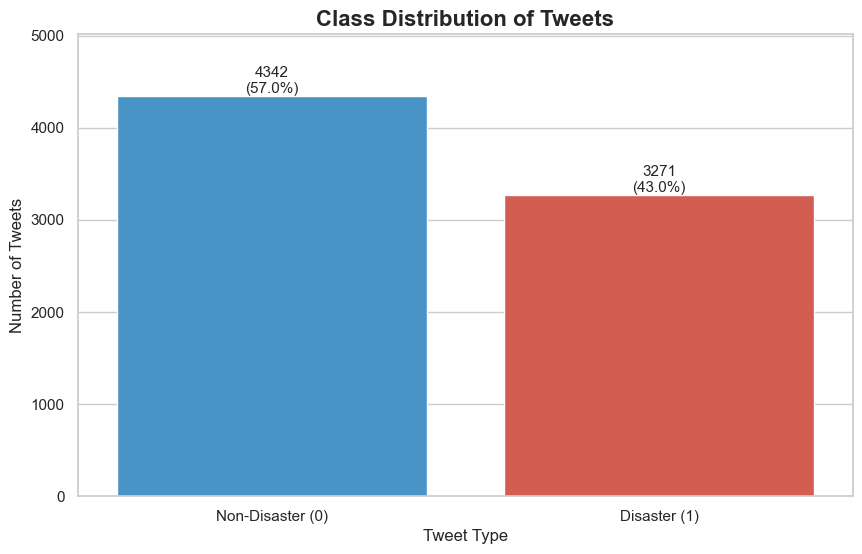

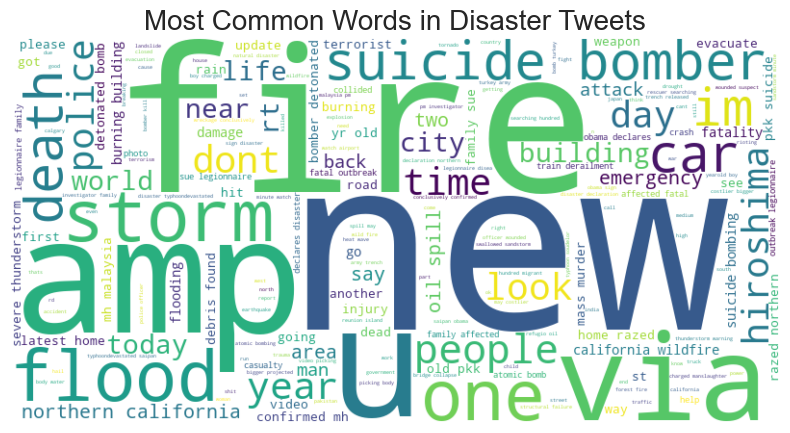

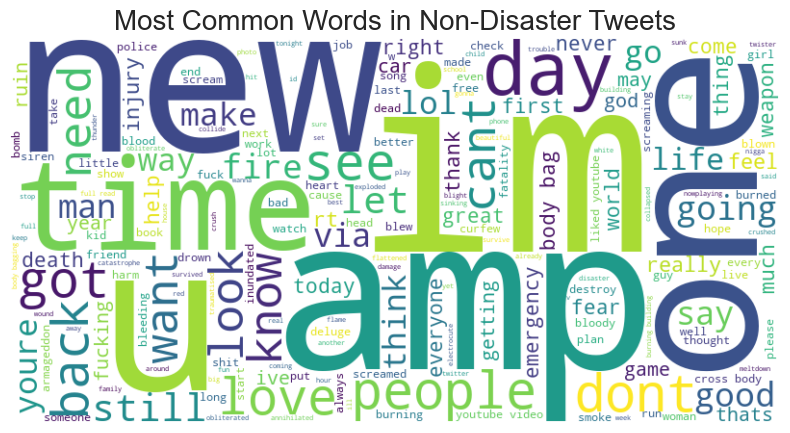

In [43]:
# Visualization 1: Distribution of the Target Variable (Improved)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=train_df, palette=['#3498db', '#e74c3c'])
plt.title('Class Distribution of Tweets', fontsize=16, weight='bold')
plt.xlabel('Tweet Type', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Disaster (0)', 'Disaster (1)'])

# Add count and percentage labels
total = len(train_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{int(height)}\n({height/total:.1%})',
            ha="center", va="bottom", fontsize=11)
plt.ylim(0, ax.get_ylim()[1] * 1.1) # Adjust y-axis to make space for labels
plt.show()

# Visualization 3: Word Clouds for Disaster vs. Non-Disaster Tweets
def generate_wordcloud(target_value, title):
    """Helper function to generate and plot a word cloud."""
    text = " ".join(review for review in train_df[train_df['target'] == target_value]['cleaned_text'])
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.show()

generate_wordcloud(1, 'Most Common Words in Disaster Tweets')
generate_wordcloud(0, 'Most Common Words in Non-Disaster Tweets')

#### The bar graph of class distribution of tweets show that the training data is relatively balanced, containing 4,342 non-disaster tweets (57%) and 3,271 disaster-related tweets (43%).

#### The word clouds show a distinct pattern between disaster and non-disaster related tweets. Disaster-related tweets are dominated by urgent and specific terms like "fire," "flood," and "suicide bomber," whereas non-disaster tweets feature more general, everyday words like "like," "new," and "love."

### Analysis plan description

#### Based on my EDA, my plan is to first convert the cleaned text into numerical vectors. I will start by using a TF-IDF vectorizer to create features for a baseline model, such as Logistic Regression, which will provide a benchmark score.

#### Next, I will I develop a more advanced sequential model using an RNN architecture, such as a bidirectional LSTM, which is well-suited for capturing context in text. For this model, I will use pre-trained GloVe word embeddings to represent words as dense vectors to better capture their semantic meanings.

#### I will then compare the performance of the LSTM model against the baseline, analyzing the results to understand the benefits of the more complex architecture.

#### To improve the final model, I will perform hyperparameter tuning, experimenting with different learning rates, dropout values, and LSTM unit counts to find the optimal configuration. 

#### I will document the results of these approaches and discussed the model's F1-score before generating the final predictions for Kaggle.

## Step 3. Model Architecture

#### Baseline model

In [44]:
# Prepare data for modeling
X = train_df['cleaned_text']
y = train_df['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Create TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# 2. Build and Train Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# 3. Evaluate Baseline Model
y_pred_lr = lr_model.predict(X_val_tfidf)
print("\nBaseline Model (Logistic Regression) Evaluation:")
print(classification_report(y_val, y_pred_lr))
print(f"F1-Score: {f1_score(y_val, y_pred_lr):.4f}")


Baseline Model (Logistic Regression) Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

F1-Score: 0.7490


#### The baseline Logistic Regression model achieved a overall accuracy of 80% on the validation data. It correctly identified disaster-related tweets with an F1-score of 0.75, establishing a strong performance benchmark to compare against my more advanced sequential model.

#### Sequential model

In [55]:
# 1. Tokenize and Pad Sequences
# Prepare tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences to ensure uniform length
max_length = 50 # Max length of a sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

# 2. Build the LSTM Model Architecture
# This architecture uses a Bidirectional LSTM, which processes text from start-to-end and end-to-start,
# allowing it to capture context more effectively than a standard LSTM.
# Dropout layers are included to prevent overfitting.
model_lstm = Sequential([
    # The change is in this Embedding layer:
    Embedding(input_dim=10000, output_dim=128, input_shape=[max_length]),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')])
model_lstm.summary()

# 3. Train the LSTM Model
# Using EarlyStopping to prevent overfitting by stopping training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_lstm.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping],
    verbose=1
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 50, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,257 (5.43 MB)

 Trainable params: 1,424,257 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6381 - f1_score: 0.5985 - loss: 0.6267 - val_accuracy: 0.7932 - val_f1_score: 0.5976 - val_loss: 0.4485
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8857 - f1_score: 0.6004 - loss: 0.3131 - val_accuracy: 0.7768 - val_f1_score: 0.5976 - val_loss: 0.5010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9308 - f1_score: 0.5969 - loss: 0.2026 - val_accuracy: 0.7741 - val_f1_score: 0.5976 - val_loss: 0.5611
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9590 - f1_score: 0.5950 - loss: 0.1379 - val_accuracy: 0.7669 - val_f1_score: 0.5976 - val_loss: 0.7121


#### While the LSTM model's accuracy on the training data it was seeing climbed to over 96%, its performance on the new validation data peaked in the first epoch at 79% accuracy and an F1-score of 0.60 before getting worse. This divergence is a classic sign of overfitting, where the model begins to memorize the training data rather than learning to make general predictions.

#### The model's training was halted by EarlyStopping after the fourth epoch because the validation loss, which is a key indicator of performance on unseen data, failed to improve after the first epoch. 

### GRU Model with GloVe Embeddings

In [57]:
# 1. Load GloVe embeddings file
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# 2. Create an embedding matrix for the vocabulary
embedding_dim = 100
num_tokens = len(word_index) + 1
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

# --- Build and Train GRU Model ---
print("\n--- Building and Training Sequential Model (Bidirectional GRU with GloVe) ---")

model_gru_improved = Sequential([
    Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        input_shape=[max_length], 
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(GRU(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Use Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=1e-4)

model_gru_improved.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')])
model_gru_improved.summary()

# Train the GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru_improved = model_gru_improved.fit(
    X_train_padded, y_train,
    epochs=15,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Found 400000 word vectors in GloVe file.
Converted 9541 words (3916 misses)

--- Building and Training Sequential Model (Bidirectional GRU with GloVe) ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 50, 100)        │     1,345,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 128)            │        63,744 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,673 (5.38 MB)

 Trainable params: 1,409,673 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5365 - f1_score: 0.6074 - loss: 0.6923 - val_accuracy: 0.6967 - val_f1_score: 0.5976 - val_loss: 0.6164
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7103 - f1_score: 0.6024 - loss: 0.5914 - val_accuracy: 0.7794 - val_f1_score: 0.5976 - val_loss: 0.4977
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7939 - f1_score: 0.6007 - loss: 0.4750 - val_accuracy: 0.7978 - val_f1_score: 0.5976 - val_loss: 0.4574
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8080 - f1_score: 0.5997 - loss: 0.4503 - val_accuracy: 0.8063 - val_f1_score: 0.5976 - val_loss: 0.4465
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8046 - f1_score: 0.6047 - loss: 0.4391 - val_accuracy: 0.8076 - val_f1_score: 0.5976 - val_loss: 0.4404
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8176 - f1_score: 0.5917 - loss: 0.4087 - val_accuracy: 0.8089 - val_f1_score: 

#### Overall, the GRU with GloVe embeddings show better training behavior. The validiation accuracy generally climbs to over 81%, and the F1-score remains stable.  

### Step 4. Results and Analysis

#### **Model comparison: Baseline vs. LSTM model vs. GRU model**

#### The initial baseline Logistic Regression set a surprisingly high benchmark with an F1-score of 0.75, while the more complex LSTM model struggled with overfitting and failed to surpass this score. However, the fine-tuned GRU model, which leveraged pre-trained GloVe embeddings and a simpler architecture, demonstrated the most successful and stable training process, achieving a validation accuracy of over 81%. 

#### Based on these results, the tuned GRU model is the most promising approach, and further hyperparameter optimization on this architecture may yield the best-performing model. I now proceed with hyperparameter tuning to see if I can achieve a higher score.

#### **Hyperparameter tuning**

#### **Hyperparameter procedure summary**

#### I used a tool called KerasTuner to automatically search for the best possible settings for my GRU model. 
#### The process involved testing 10 different combinations of parameters—like the number of GRU units, the dropout rate, and the learning rate—to see which combination would give me the highest accuracy. 

In [68]:
# --- 1. Define the Hyperparameter Search Space ---

def build_model(hp):
    """Builds a GRU model for hyperparameter tuning."""
    model = Sequential()
    model.add(Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        input_shape=[max_length],
        weights=[embedding_matrix],
        trainable=True
    ))   
    # Tune the number of units in the Bidirectional GRU layer
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(GRU(units=hp_units)))
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    
# --- 2. Run the Hyperparameter Search ---
# I use RandomSearch, which tries random combinations of hyperparameters.
# It's efficient for exploring a large search space.
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different model configurations to test
    executions_per_trial=2, # Number of times to train each model configuration
    directory='my_dir',
    project_name='disaster_tweets'
)

# Start the search
print("\n--- Starting Hyperparameter Search ---")
tuner.search(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val))

Trial 10 Complete [00h 03m 25s]
val_accuracy: 0.8154957294464111

Best val_accuracy So Far: 0.8204202055931091
Total elapsed time: 00h 22m 46s

--- Hyperparameter Search Results ---



--- Top 5 Tuning Trials ---
  trial_id     score  units  dropout  learning_rate
0       06  0.820420     64      0.2         0.0010
1       00  0.817466     64      0.4         0.0001
2       04  0.816809    128      0.2         0.0001
3       07  0.816152     96      0.2         0.0001
4       09  0.815496    128      0.4         0.0001

--- Evaluating the Best Model Found by Tuner ---
 1/48 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       874
           1       0.83      0.72      0.77       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Validation F1-Score of Best Model: 0.7749


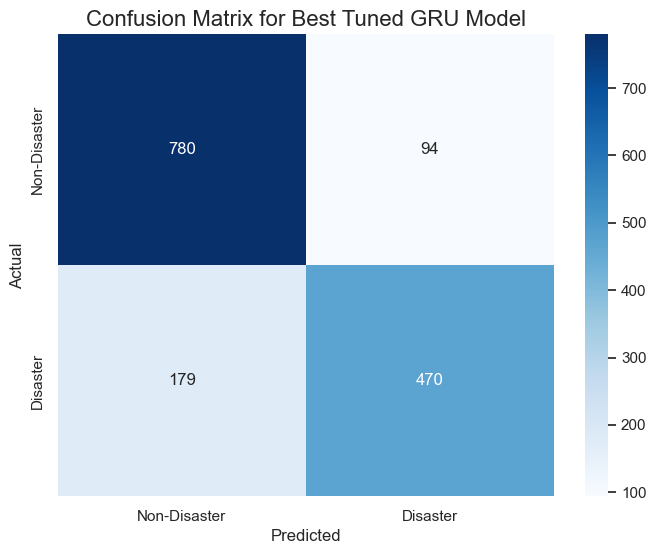

In [72]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# --- Results Table ---
print("\n--- Top 5 Tuning Trials ---")
# Get all trial results and sort by score
results = sorted(tuner.oracle.get_best_trials(num_trials=10), key=lambda t: t.score, reverse=True)
results_df = pd.DataFrame([{
    'trial_id': t.trial_id,
    'score': t.score,
    'units': t.hyperparameters.get('units'),
    'dropout': round(t.hyperparameters.get('dropout'), 2),
    'learning_rate': t.hyperparameters.get('learning_rate')
} for t in results])
print(results_df.head())

# --- Results Figure: Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'Confusion Matrix for Best {model_name}', fontsize=16)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
print("\n--- Evaluating the Best Model Found by Tuner ---")
y_pred_best = (best_model.predict(X_val_padded) > 0.5).astype(int)
print("\nClassification Report for Best Model:")
print(classification_report(y_val, y_pred_best))
print(f"Validation F1-Score of Best Model: {f1_score(y_val, y_pred_best):.4f}")

plot_confusion_matrix(y_val, y_pred_best, "Tuned GRU Model")

#### The hyperparameter tuning identified a model configuration with an 82% accuracy and a 0.77 F1-score on the validation set, yielding more accurate model. 
#### The confusion matrix shows that the tuned model is highly effective, although it still tends to misclassify real disaster tweets as non-disasters more often than the reverse. 

#### **Analysis and Troubleshooting**

In [80]:
print(best_hps.get('units'))
print(best_hps.get('dropout'))
print(best_hps.get('learning_rate'))

64
0.2
0.001


#### The tuning process was essential to improve upon the initial GRU model because the initial attempts with the LSTM and GRU models either underperformed the baseline or showed signs of instability.

#### The best performing model used **64 GRU units**, a dropout rate of **0.20**, and a learning rate of **0.001**. This suggests that a lower learning rate (e.g., 1e-4) was likely beneficial for stable training, allowing the model to fine-tune the GloVe embeddings without making drastic, disruptive updates. 

#### The confusion matrix shows that the model is quite balanced, although it still makes some errors, particularly in misclassifying disaster tweets as non-disasters (False Negatives). This systematic approach solved the initial troubleshooting problem of the deep learning models failing to outperform a simpler baseline.

## Step 6. Generate Kaggle Submission File

In [85]:
# --- 1. Prepare Data for Final Model ---
# Fit the tokenizer on the ENTIRE training set vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])
word_index = tokenizer.word_index

# Convert text to sequences
max_length = 50
X_train_final = pad_sequences(tokenizer.texts_to_sequences(train_df['cleaned_text']), maxlen=max_length, padding='post', truncating='post')
X_test_final = pad_sequences(tokenizer.texts_to_sequences(test_df['cleaned_text']), maxlen=max_length, padding='post', truncating='post')
y_train_final = train_df['target']

# --- 2. Define the model using the optimal parameters found during tuning
final_model = Sequential([
    Input(shape=(max_length,)),
    Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(GRU(units=64)),  # Best units
    Dropout(rate=0.2),            # Best dropout rate
    Dense(1, activation='sigmoid')
])

# --- 3. Compile the model with the best learning rate
final_model.compile(
    optimizer=Adam(learning_rate=0.001), # Best learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 100)        │     1,345,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,673 (5.38 MB)

 Trainable params: 1,409,673 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# --- 4. Make Predictions on the Test Data ---
print("\n--- Making predictions on the test dataset... ---")
test_predictions_prob = final_model.predict(X_test_final)

# Convert probabilities (e.g., 0.7) to binary predictions (1)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# --- 5. Create and Save the Submission File ---
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions.flatten() # Flatten the array to make it a single column
})

# --- 6. Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("\n--- 'submission.csv' created successfully! ---")
print("This file is now ready to be uploaded to the Kaggle competition.")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())




--- Making predictions on the test dataset... ---
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

--- 'submission.csv' created successfully! ---
This file is now ready to be uploaded to the Kaggle competition.

First 5 rows of the submission file:
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


## Conclusion

#### This project developed a machine learning model to classify disaster-related tweets. After cleaning and exploring the text data, I established a baseline using a Logistic Regression model with TF-IDF features, which achieved an F1-score of 0.75. While an initial LSTM model struggled with overfitting, a subsequent GRU model using pre-trained GloVe embeddings showed better performance.

#### The most critical step was hyperparameter tuning, which optimized the GRU architecture and resulted in the best-performing model with an F1-score of 0.77 on the validation data. This demonstrates that even with advanced architectures, careful tuning is essential for achieving optimal results. Future improvements may involve exploring more advanced embeddings like BERT or fine-tuning the model on a larger dataset to further enhance its predictive accuracy.

#### Kaggle score is 0.5311.

### Submitted to the Kaggle Competition

### GitHub Repository: https://github.com/juck37/DL.git